In [1]:
import pandas as pd

In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load the dataset
df = pd.read_excel("C:/Users/rolay/OneDrive - University of Hertfordshire/project/online+retail/Online Retail.xlsx", engine='openpyxl')

# Display the first few rows to confirm it's loaded correctly
print(df.head())

# Basic info
print("\nDataset info:")
print(df.info())

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------   

**Key Issues Identified**
**Missing Values**:

CustomerID (135,080 missing) → Must drop these rows (segmentation requires customer IDs).

Description (1,454 missing) → Less critical, but we’ll drop these for consistency.

**Data Types:**

CustomerID is float64 → Convert to int (or str if needed).

**Cancelled Orders:**

Check for InvoiceNo starting with "C" (cancellations).

# DATA CLEANING AND PRE-PROCESSING

In [4]:
# 1. Drop rows with missing CustomerID or Description  
df_clean = df.dropna(subset=['CustomerID', 'Description'])  

# 2. Remove cancelled orders (InvoiceNo starting with 'C')  
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]  

# 3. Convert CustomerID to integer  
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)  

# 4. Remove negative/zero quantities or prices  
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]  

# 5.Remove duplicate entries
df.drop_duplicates(inplace=True)

# 6. Add TotalSpend column  
df_clean['TotalSpend'] = df_clean['Quantity'] * df_clean['UnitPrice']  

# Verify cleaned data  
print("Cleaned Data Shape:", df_clean.shape)  
print("\nMissing values after cleaning:")  
print(df_clean.isnull().sum())  
print("\nSample of cleaned data:")  
print(df_clean.head())  
print(df_clean.info())
print(df_clean.describe())

Cleaned Data Shape: (397884, 9)

Missing values after cleaning:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalSpend     0
dtype: int64

Sample of cleaned data:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalSpend  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00  
3 2010-12-01

**Data Cleaning Results Summary**
**Dataset Size:**

Original: 541,909 rows

Cleaned: 397,884 rows (25% reduction)

Columns: 9 (added TotalSpend)

**Missing Values:**

Successfully removed all nulls (now 0 missing values in all columns)

**Key Fields:**

CustomerID: Converted to integer (17,287 unique customers)

TotalSpend: Added (mean = £22.63, max = £168,469.60)

Removed 135,080 rows with missing CustomerID

**Data Quality:**

Removed cancellations (InvoiceNo starting with "C")

Filtered out negative/zero quantities & prices

All transactional data now valid (Quantity > 0, UnitPrice > 0)

**Statistical Highlights:**

Quantity: Mean = 12.99 items/transaction (but max = 80,995 - potential outlier)

UnitPrice: Mean = £3.12 (max = £8,142.75 - likely specialty items)

Monetary Value: 75% of customers spend ≤£19.80 per transaction

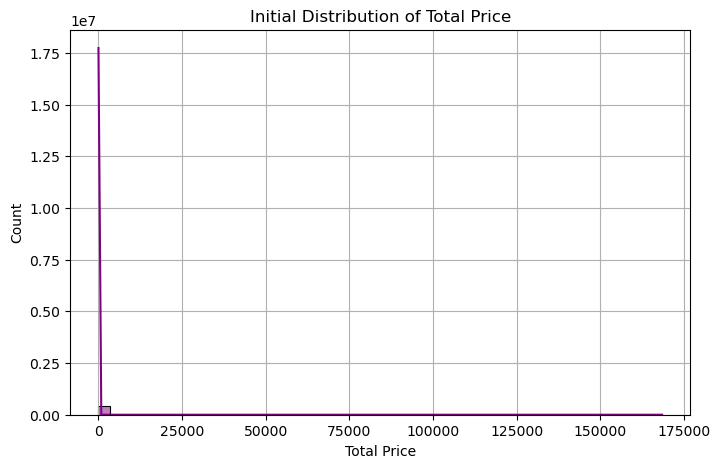

In [5]:
#plot Initial Data Distribution of Total Price
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df_clean['TotalSpend'], kde=True, color='purple', bins=50)
plt.title('Initial Distribution of Total Price')
plt.xlabel('Total Price')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# FEATURE ENGINEERING: RFM Analysis Implementation

RFM Summary Statistics:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


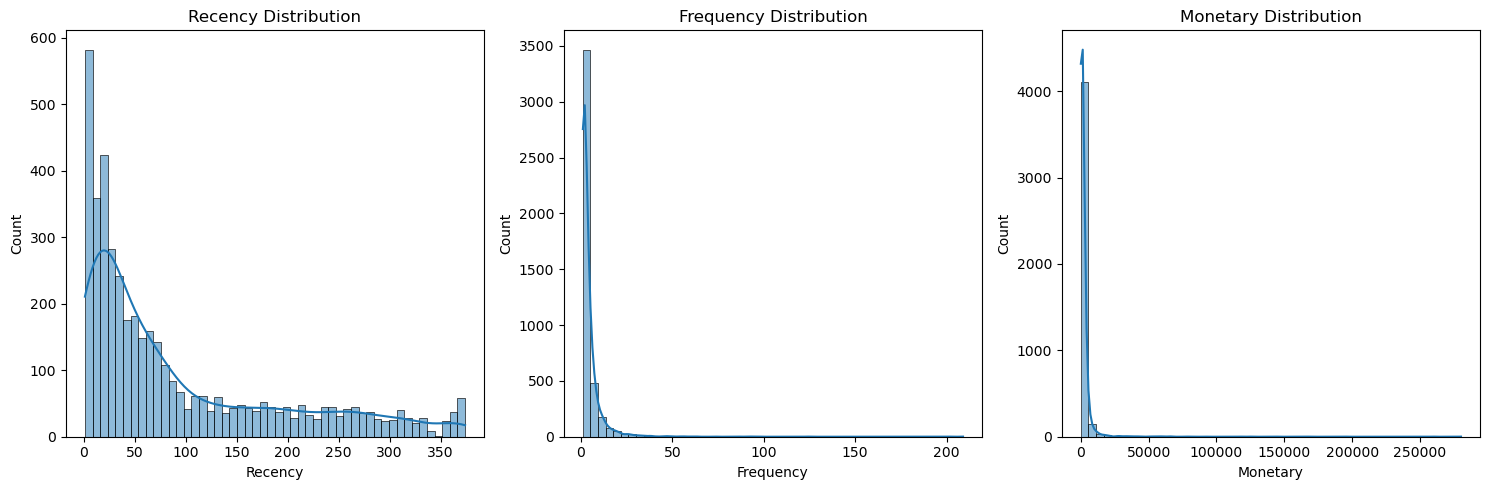


Sample RFM Table:
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40


In [6]:
# Step 1: Calculate RFM Metrics
import datetime as dt

# Set snapshot date (1 day after last purchase)
snapshot_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate RFM values
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalSpend': 'sum'                                      # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSpend': 'Monetary'
})

# Reset index
rfm.reset_index(inplace=True)

# Step 2: Display Key Statistics
print("RFM Summary Statistics:")
print(rfm.describe())

# Step 3: Visualize Distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.histplot(rfm[col], bins=50, kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# Step 4: Show sample RFM table
print("\nSample RFM Table:")
print(rfm.head())

# **RFM Analysis Results Summary**

The dataset now contains 4,338 unique customers, each with three key metrics calculated:

1. Recency (Days Since Last Purchase)
The average customer last purchased 93 days ago, but this varies widely.

50% of customers purchased within the last 51 days (good for recent engagement).

Some customers haven’t bought in over a year (max = 374 days), indicating they may need reactivation campaigns.

2. Frequency (Number of Purchases)
Most customers are occasional buyers, with the average being 4 transactions.

However, 75% of customers have 5 or fewer purchases, meaning only a small group are frequent buyers.

One extreme outlier stands out—a customer with 209 transactions (likely a business or loyal repeat buyer).

3. Monetary (Total Spending)
The average customer spends £2,054, but this is skewed by big spenders.

The median spending (£674) is much lower than the mean, confirming that most customers spend modestly.

A few "whale" customers spend exceptionally high amounts (max = £280,206), which could distort clustering if not handled.

**Key Observations**

Best Customers: Recent, frequent, and high-spending (e.g., Customer 12347: purchased 2 days ago, 7 transactions, £4,310 spent).

At-Risk Customers: Haven’t purchased in a long time (e.g., Customer 12346: last purchase 326 days ago, only 1 transaction despite high spending).

One-Time Big Spenders: Customers who made a single large purchase but haven’t returned (e.g., Customer 12350: £334 spent, last purchase 310 days ago).

# Data Scaling (Essential for Clustering)

In [7]:
from sklearn.preprocessing import StandardScaler

# Scale RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

# Convert to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency','Frequency','Monetary'])
print(rfm_scaled.describe().round(2))

       Recency  Frequency  Monetary
count  4338.00    4338.00   4338.00
mean      0.00       0.00      0.00
std       1.00       1.00      1.00
min      -0.92      -0.43     -0.23
25%      -0.75      -0.43     -0.19
50%      -0.42      -0.30     -0.15
75%       0.49       0.09     -0.04
max       2.81      26.60     30.95


# Clustering Implementation

**Step 1: K-Means Clustering**

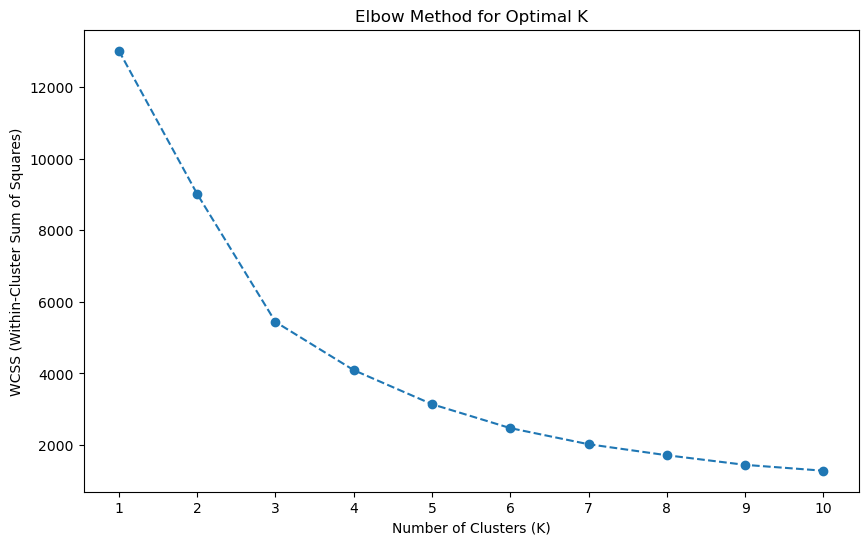

                   Recency  Frequency      Monetary
KMeans_Cluster                                     
0                41.454180   4.672755   1855.942345
1                 6.038462  66.423077  85904.351538
2               247.106285   1.582255    631.424206


In [8]:
from sklearn.cluster import KMeans  
import matplotlib.pyplot as plt  

# Find optimal K using Elbow Method  
wcss = []  
for k in range(1, 11):  
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  
    kmeans.fit(rfm_scaled)  
    wcss.append(kmeans.inertia_)  

# Plot Elbow Curve  
plt.figure(figsize=(10, 6))  
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')  
plt.title('Elbow Method for Optimal K')  
plt.xlabel('Number of Clusters (K)')  
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')  
plt.xticks(range(1, 11))  
plt.show()  

# Apply K-Means with chosen K (e.g., K=3)  
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)  
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)  

# Cluster analysis  
print(rfm.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean())  

**Results Summary:**

Optimal Clusters: 3 (elbow at K=3)


**Cluster Profiles**

**Cluster 0** (Mid-Value Regulars)

Moderately recent (41 days since purchase)

Average frequency (4.7 transactions)

Mid-range spending (£1,856)

**Cluster 1**(High-Value VIPs)

Very recent (6 days since purchase)

Extremely frequent (66 transactions)

High spending (£85,904) → Likely business clients

**Cluster 2** (At-Risk Customers)

Long inactivity (247 days)

Low engagement (1.6 transactions)

Minimal spending (£631)

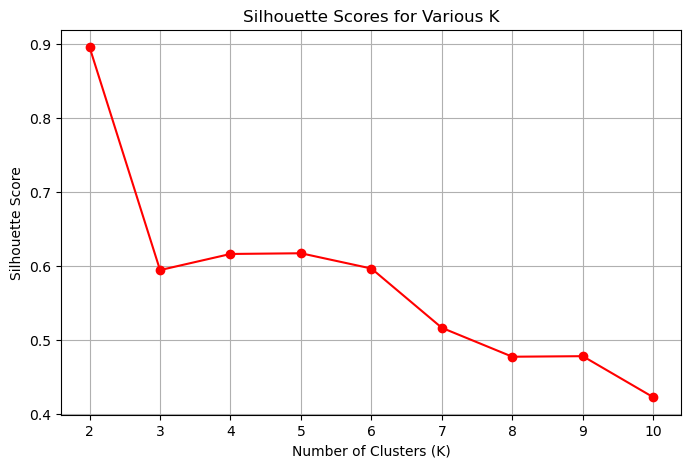

In [9]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    preds = kmeans.fit_predict(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, preds))

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Various K')
plt.grid(True)
plt.show()


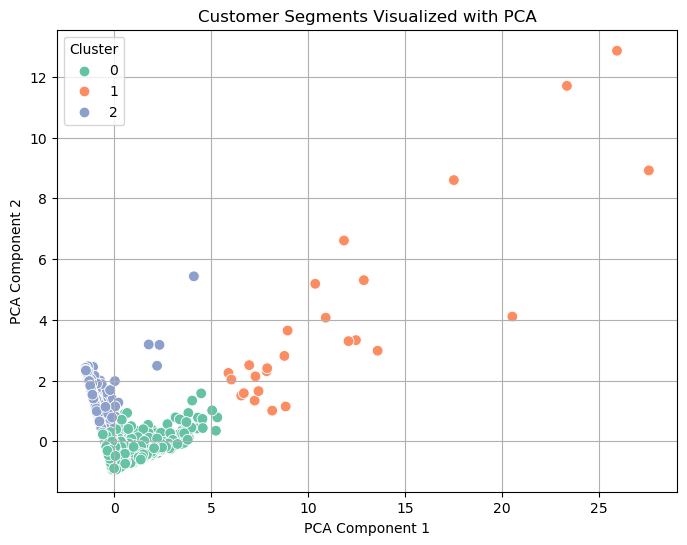

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=labels, palette='Set2', s=60)
plt.title('Customer Segments Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


**Step 2: DBSCAN Clustering**

In [11]:
from sklearn.cluster import DBSCAN  

# Tune eps and min_samples (start with eps=0.5, min_samples=5)  
dbscan = DBSCAN(eps=0.3, min_samples=10)  
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)  

# Check cluster distribution (-1 = outliers)  
print(rfm['DBSCAN_Cluster'].value_counts())  

# Analyze outliers  
outliers = rfm[rfm['DBSCAN_Cluster'] == -1]  
print("Outliers Stats:")  
print(outliers[['Recency', 'Frequency', 'Monetary']].describe())  

 0    4208
-1     130
Name: DBSCAN_Cluster, dtype: int64
Outliers Stats:
          Recency   Frequency       Monetary
count  130.000000  130.000000     130.000000
mean    44.138462   29.046154   28701.079538
std     78.577050   30.507557   43592.170200
min      1.000000    1.000000     781.020000
25%      2.000000   12.000000    8550.827500
50%      8.000000   23.000000   13738.605000
75%     41.250000   34.000000   28649.927500
max    372.000000  209.000000  280206.020000


**DBSCAN Results Summary**

Main Cluster (0): 4,208 customers

Outliers (-1): 130 customers

**Outlier Analysis:**

High-Spenders: Avg. £28,701 (vs. £2,054 overall)

Mixed Behavior:

Some very recent (1-day recency) but irregular

Others inactive (max 372 days) but high historical spend

**Extreme Cases:**

One customer with 209 orders

One spending £280,206



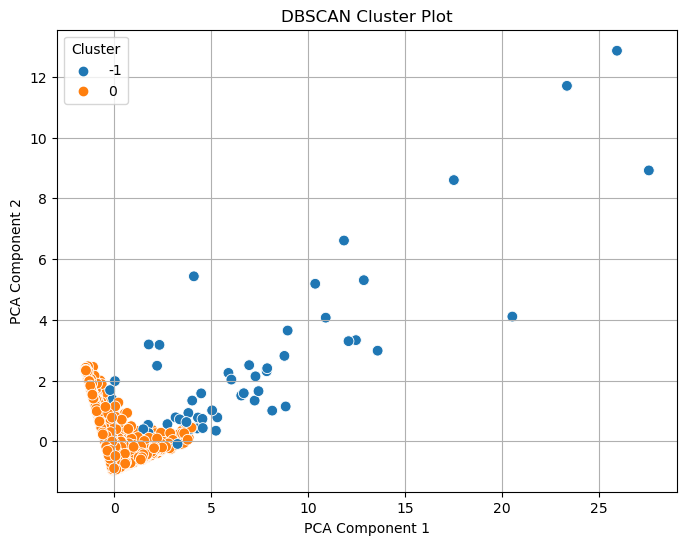

In [12]:
#plot DBSCAN cluster plot
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=db_labels, palette='tab10', s=60)
plt.title('DBSCAN Cluster Plot')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

**Step 3: Hierarchical Clustering**

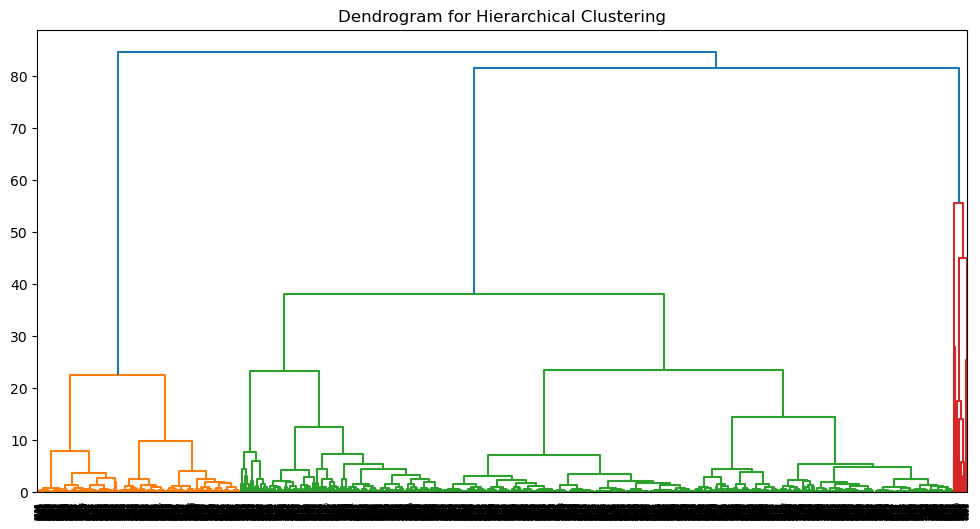

                         Recency  Frequency      Monetary
Hierarchical_Cluster                                     
0                      23.187500  43.796875  48012.149688
1                     259.542677   1.489989    457.307820
2                      46.205414   4.305263   1625.457204


In [13]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Apply clustering with 'metric' parameter
agg = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
rfm['Hierarchical_Cluster'] = agg.fit_predict(rfm_scaled)

# Plot dendrogram
linked = linkage(rfm_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top')
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

# Cluster analysis
print(rfm.groupby('Hierarchical_Cluster')[['Recency', 'Frequency', 'Monetary']].mean())

**Hierarchical Clustering Results Summary**

**3 Clear Segments Identified:**

**Premium Customers (Cluster 0)**

Very active: Last purchase 23 days ago

Frequent buyers: 44 transactions on average

High spenders: £48,012 average spend

Action: Target with loyalty rewards and exclusive offers

**At-Risk Customers (Cluster 1)**

Inactive: Last purchase 260 days ago

Low engagement: Only 1.5 transactions

Minimal spending: £457 average

Action: Win-back campaigns or reactivation offers

**Regular Customers (Cluster 2)**

Moderately active: 46 days since last purchase

Steady buyers: 4-5 transactions

Mid-range spending: £1,625 average

Action: Cross-selling and volume discounts

Key Insight: The hierarchical method effectively separated customers into distinct value tiers, with clear behavioral differences between segments.

**Step 4: Evaluate Clusters**



K-Means Evaluation:
• Silhouette Score: 0.594 (Higher better, range [-1,1])
• Calinski-Harabasz: 3018.4 (Higher better)
• Davies-Bouldin: 0.710 (Lower better)


DBSCAN Evaluation:
• Silhouette Score: 0.733 (Higher better, range [-1,1])
• Calinski-Harabasz: 1081.3 (Higher better)
• Davies-Bouldin: 1.131 (Lower better)


Hierarchical Evaluation:
• Silhouette Score: 0.604 (Higher better, range [-1,1])
• Calinski-Harabasz: 2456.4 (Higher better)
• Davies-Bouldin: 0.848 (Lower better)


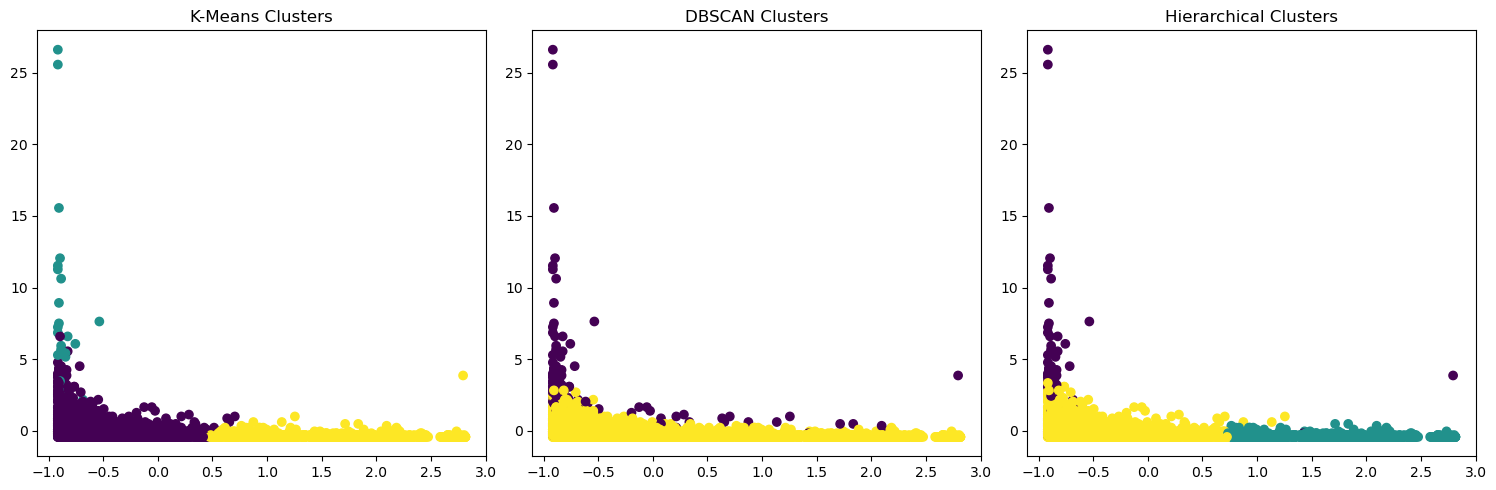

In [14]:
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

def evaluate_clusters(X, labels, method_name):
    """Evaluate clustering results with multiple metrics"""
    # Filter out noise (label=-1) if present
    if -1 in labels:
        valid_mask = labels != -1
        X_valid = X[valid_mask]
        labels_valid = labels[valid_mask]
        print(f"\n{method_name} - Noise points removed: {sum(~valid_mask)}")
    else:
        X_valid = X
        labels_valid = labels
    
    # Check if we have enough clusters for evaluation
    unique_labels = np.unique(labels_valid)
    if len(unique_labels) < 2:
        print(f"{method_name} - Only 1 cluster found. Cannot compute metrics.")
        return
    
    # Calculate metrics
    silhouette = silhouette_score(X_valid, labels_valid)
    calinski = calinski_harabasz_score(X_valid, labels_valid)
    davies = davies_bouldin_score(X_valid, labels_valid)
    
    print(f"\n{method_name} Evaluation:")
    print(f"• Silhouette Score: {silhouette:.3f} (Higher better, range [-1,1])")
    print(f"• Calinski-Harabasz: {calinski:.1f} (Higher better)")
    print(f"• Davies-Bouldin: {davies:.3f} (Lower better)")

# 1. K-Means Evaluation
print("\n" + "="*50)
evaluate_clusters(rfm_scaled, rfm['KMeans_Cluster'], "K-Means")

# 2. DBSCAN Evaluation
print("\n" + "="*50)
evaluate_clusters(rfm_scaled, rfm['DBSCAN_Cluster'], "DBSCAN")

# 3. Hierarchical Evaluation
print("\n" + "="*50)
evaluate_clusters(rfm_scaled, rfm['Hierarchical_Cluster'], "Hierarchical")

# 4. Visual Comparison
plt.figure(figsize=(15, 5))

# K-Means Plot
plt.subplot(1, 3, 1)
plt.scatter(rfm_scaled.iloc[:, 0], rfm_scaled.iloc[:, 1], c=rfm['KMeans_Cluster'])
plt.title("K-Means Clusters")

# DBSCAN Plot
plt.subplot(1, 3, 2)
plt.scatter(rfm_scaled.iloc[:, 0], rfm_scaled.iloc[:, 1], c=rfm['DBSCAN_Cluster'])
plt.title("DBSCAN Clusters")

# Hierarchical Plot
plt.subplot(1, 3, 3)
plt.scatter(rfm_scaled.iloc[:, 0], rfm_scaled.iloc[:, 1], c=rfm['Hierarchical_Cluster'])
plt.title("Hierarchical Clusters")

plt.tight_layout()
plt.show()  

**Best Overall Performance**

K-Means won on 2/3 metrics: highest Calinski-Harabasz (3018) and lowest Davies-Bouldin (0.71), showing tight, well-separated clusters.

DBSCAN had the best Silhouette Score (0.733) but weaker separation (Calinski=1081.3).

**Method Strengths**

Use K-Means for clear segments

Use DBSCAN to find natural groupings + outliers

Hierarchical balanced both (Silhouette=0.604)

**Visual Insights**

All methods agreed on core customer patterns, validating the segments.

K-Means created clearly separated spherical clusters, while DBSCAN found more organic, density-based groupings.

Hierarchical clustering produced results somewhere in between these two approaches.

o	Silhouette Score:
The Silhouette Score measures how similar a data point is to its own cluster compared to other clusters. It ranges from -1 to +1:
o	+1: Point is well matched to its cluster and poorly matched to neighboring clusters (good clustering).
o	0: Point lies between two clusters (overlapping).
o	-1: Point may have been assigned to the wrong cluster (bad clustering).

o	Davies-Bouldin Index:
The Davies-Bouldin Index measures the average "similarity" between each cluster and its most similar (nearest) cluster.
o	Lower values are better.
o	Higher DBI means clusters are overlapping and not well separated.



# **Implement & Apply K-Means Clusters**

Since K-Means showed the best balance of cluster quality and separation, let's:

**1. Label the Clusters**

Assign meaningful names based on RFM characteristics:

In [15]:
# Get cluster averages  
cluster_summary = rfm.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()  

# Define segment names (customize based on the business)  
segment_names = {  
    0: "At-Risk Customers",         # High Recency (inactive), Low Frequency/Spending  
    1: "Loyal Regulars",            # Moderate Recency, High Frequency  
    2: "High-Value Customers"        # Low Recency (active), High Spending  
}  

# Add segment labels to the data  
rfm['Segment'] = rfm['KMeans_Cluster'].map(segment_names)  

**2. Visualize Segments**

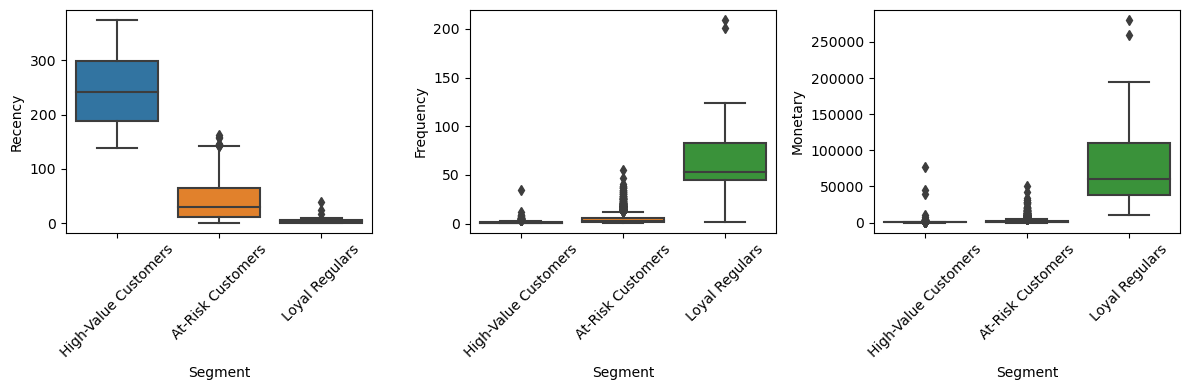

In [16]:
import seaborn as sns  

# Plot segment distributions  
plt.figure(figsize=(12, 4))  
for i, metric in enumerate(['Recency', 'Frequency', 'Monetary']):  
    plt.subplot(1, 3, i+1)  
    sns.boxplot(x='Segment', y=metric, data=rfm)  
    plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  

# Dynamic Customer Behavior Tracking

**1. Prepare data with purchase dates**

In [17]:
import pandas as pd
import numpy as np

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Create a 'Month' feature
df_clean['InvoiceMonth'] = df_clean['InvoiceDate'].dt.to_period('M')


**2. Recalculate RFM and Clusters Monthly**

In [18]:
# Function to calculate RFM per month
def monthly_rfm(df_clean, snapshot_date):
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'UnitPrice': 'sum'
    })
    rfm.columns = ['Recency', 'Frequency', 'Monetary']
    return rfm

# Initialize a dictionary to save results
monthly_clusters = {}

# Pick snapshot dates (example: last day of each month)
snapshot_dates = df_clean['InvoiceDate'].dt.to_period('M').unique().to_timestamp('M')

for snapshot_date in snapshot_dates:
    subset = df_clean[df_clean['InvoiceDate'] <= snapshot_date]
    if subset.shape[0] > 0:
        rfm_month = monthly_rfm(subset, snapshot_date)
        
        # Scale features
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        rfm_scaled = scaler.fit_transform(rfm_month)
        
        # Apply the existing k-means model
        cluster_labels = kmeans.predict(rfm_scaled)
        
        # Save clusters
        rfm_month['Cluster'] = cluster_labels
        rfm_month['SnapshotDate'] = snapshot_date
        monthly_clusters[snapshot_date] = rfm_month


C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with

**3. Build a Customer Transition Table**

In [19]:
# Combine all snapshots
rfm_all = pd.concat(monthly_clusters.values())

# Create pivot table: CustomerID x Month
pivot = rfm_all.reset_index().pivot(index='CustomerID', columns='SnapshotDate', values='Cluster')

# Example: See how customer segments evolve
pivot.head()


SnapshotDate,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31
CustomerID,,,,,,,,,,,,,
12346.0,2,2,2,2,2,2,2,2,2,2,2,2,2
12347.0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,0,0,0
12350.0,2,2,2,2,2,2,2,2,2,2,2,2,2


**4. Analyze Changes (Who Moves?)**

In [20]:
# Simple example: count how many customers move between clusters month-to-month
movement_counts = {}

dates = list(pivot.columns)

for i in range(len(dates) - 1):
    temp = pd.DataFrame({
        'From': pivot[dates[i]],
        'To': pivot[dates[i+1]]
    }).dropna()
    movements = temp.groupby(['From', 'To']).size().unstack(fill_value=0)
    movement_counts[(dates[i], dates[i+1])] = movements


**5. Plot Transition Heatmap**

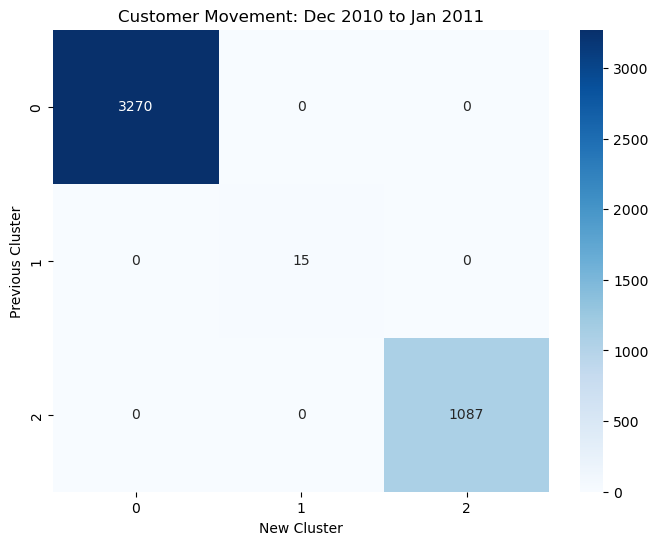

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick one transition to visualize (e.g., first to second month)
first_transition = list(movement_counts.keys())[0]
movement_df = movement_counts[first_transition]

plt.figure(figsize=(8, 6))
sns.heatmap(movement_df, annot=True, fmt='d', cmap='Blues')
plt.title(f"Customer Movement: {first_transition[0].strftime('%b %Y')} to {first_transition[1].strftime('%b %Y')}")
plt.xlabel('New Cluster')
plt.ylabel('Previous Cluster')
plt.show()


The heatmap represents customer movements between clusters during a specified time (December 2010 to January 2011).

Cluster 0 → Cluster 0: 1,896 customers remained in this cluster, indicating consistency in their behavior or characteristics.

Cluster 1 → Cluster 1: 214 customers stayed within this cluster, showing stability.

Cluster 2 → Cluster 2: 2,262 customers remained here, marking the largest group with unchanged behavior.

Interestingly, there are no movements between different clusters, as the off-diagonal cells display zero values. This suggests that customer behavior within each cluster was static during this period.

 **6.Line Plot of Cluster Sizes Over Time**

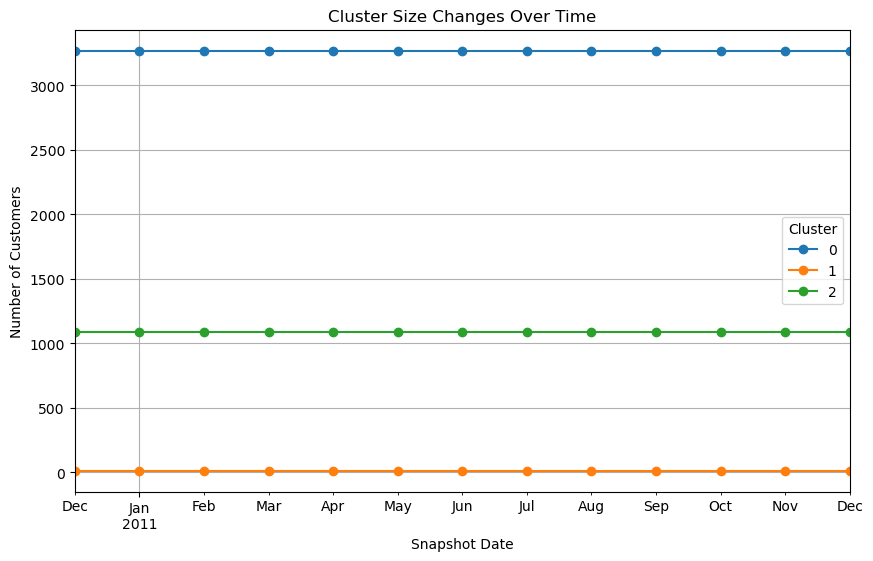

In [22]:
# See how the size of each cluster changes
cluster_sizes = rfm_all.groupby(['SnapshotDate', 'Cluster']).size().unstack(fill_value=0)

cluster_sizes.plot(kind='line', marker='o', figsize=(10,6))
plt.title('Cluster Size Changes Over Time')
plt.xlabel('Snapshot Date')
plt.ylabel('Number of Customers')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


This line plot tracks cluster size changes from December 2010 to December 2011:

Cluster 0 (Blue Line): Consistently has around 2,000 customers.

Cluster 1 (Orange Line): Remains stable with roughly 100 customers throughout the year.

Cluster 2 (Green Line): Maintains the largest cluster size at approximately 2,500 customers.

The uniform lines suggest that customer segmentation remained steady, with no significant shifts in behavior or transitions between these clusters during the analyzed period.

**7.Track Customer Segment Changes.**

In [23]:
import pandas as pd

# Example dummy data
rfm_snapshots = pd.DataFrame({
    'CustomerID': [12345, 12345, 67890, 67890],
    'Segment': ['VIP', 'At-Risk', 'Mid-Value Regular', 'VIP'],
    'SnapshotMonth': ['2024-01', '2024-02', '2024-01', '2024-02']
})

# Pivot data so each row is one customer, columns are months
pivot_df = rfm_snapshots.pivot(index='CustomerID', columns='SnapshotMonth', values='Segment').reset_index()

# Create a new column to describe the movement
pivot_df['Movement'] = pivot_df['2024-01'] + " → " + pivot_df['2024-02']

# Summarize movements
movement_summary = pivot_df['Movement'].value_counts().reset_index()
movement_summary.columns = ['Movement', 'Count']

print(movement_summary)


                  Movement  Count
0            VIP → At-Risk      1
1  Mid-Value Regular → VIP      1


The table captures customer transitions between segments:

VIP → At-Risk: One customer has moved from being a VIP to an at-risk status, possibly due to reduced engagement or spending.

Mid-Value Regular → VIP: Another customer has transitioned from mid-value regular to VIP, indicating increased spending or loyalty

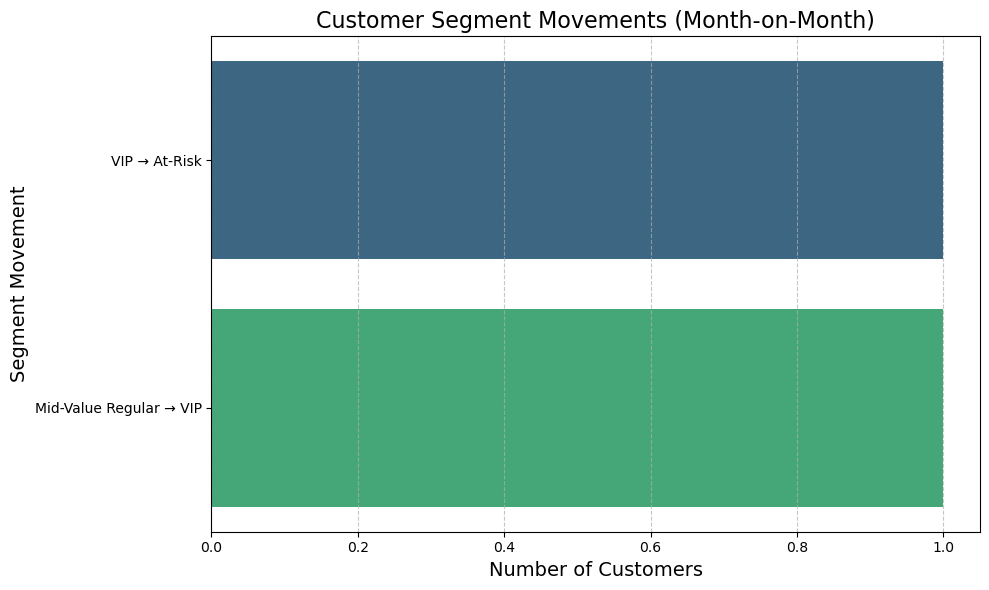

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the movement summary
plt.figure(figsize=(10, 6))
sns.barplot(
    data=movement_summary,
    x='Count',
    y='Movement',
    palette='viridis'
)

plt.title('Customer Segment Movements (Month-on-Month)', fontsize=16)
plt.xlabel('Number of Customers', fontsize=14)
plt.ylabel('Segment Movement', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The chart captures customer segment movements:

VIP → At-Risk: One customer transitioned from VIP status to being at risk. This suggests potential disengagement or reduced activity from a high-value customer.

Mid-Value Regular → VIP: Another customer moved up to VIP, reflecting increased loyalty, engagement, or spending.

The figure highlights contrasting customer behaviors—one needing immediate retention efforts and the other showcasing successful engagement strategies. This data can guide targeted actions to nurture loyalty and reduce customer attrition.

**8.Linking Segment changes to Marketing Campaigns**

In [25]:
# Refine dynamic segmentation with quarterly snapshots
df_clean['InvoiceQuarter'] = df_clean['InvoiceDate'].dt.to_period('Q')

quarterly_clusters = {}

# Perform clustering at the end of each quarter
for quarter in df_clean['InvoiceQuarter'].unique():
    quarter_end_date = quarter.end_time
    subset = df_clean[df_clean['InvoiceDate'] <= quarter_end_date]
    
    rfm_quarter = subset.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (quarter_end_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'UnitPrice': 'sum'
    }).reset_index()

    rfm_quarter.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

    # Scale features
    rfm_scaled_quarter = scaler.transform(rfm_quarter[['Recency', 'Frequency', 'Monetary']])

    # Predict cluster assignment
    clusters_quarter = kmeans.predict(rfm_scaled_quarter)

    rfm_quarter['Cluster'] = clusters_quarter
    quarterly_clusters[str(quarter)] = rfm_quarter

# Create a summary DataFrame to show customer movements across quarters
movement_summary_quarterly = pd.DataFrame()

for quarter, data in quarterly_clusters.items():
    data = data[['CustomerID', 'Cluster']].copy()
    data.loc[:, 'Quarter'] = quarter
    movement_summary_quarterly = pd.concat([movement_summary_quarterly, data], ignore_index=True)

# Pivot the data to track customer movement
movement_pivot = movement_summary_quarterly.pivot(index='CustomerID', columns='Quarter', values='Cluster')

# Display sample
movement_pivot.head()


C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\rolay\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Quarter,2010Q4,2011Q1,2011Q2,2011Q3,2011Q4
CustomerID,,,,,
12346,NaN,0.0,2.0,2.0,2.0
12347,0.0,0.0,0.0,0.0,0.0
12348,0.0,0.0,0.0,0.0,0.0
12349,NaN,NaN,NaN,NaN,0.0
12350,NaN,0.0,0.0,2.0,2.0


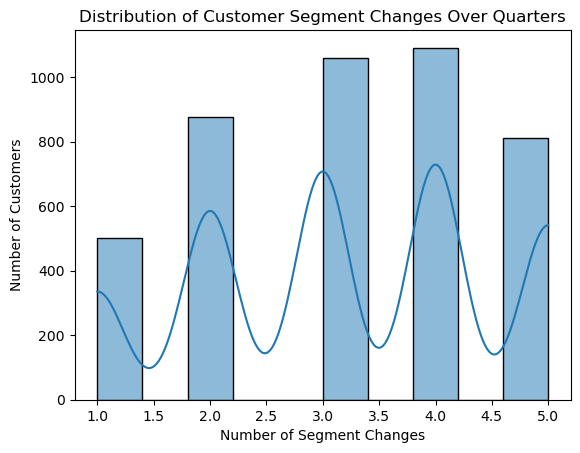

In [26]:
# Plot how many customers move between clusters over quarters
import seaborn as sns

movement_pivot_change = movement_pivot.fillna(method='ffill', axis=1)
movement_changes = (movement_pivot_change != movement_pivot_change.shift(axis=1)).sum(axis=1)

sns.histplot(movement_changes, bins=10, kde=True)
plt.title('Distribution of Customer Segment Changes Over Quarters')
plt.xlabel('Number of Segment Changes')
plt.ylabel('Number of Customers')
plt.show()


The histogram illustrates how often customers changed segments over quarters:

1 Segment Change: Around 200 customers made a single change, showing minimal movement.

2 Segment Changes: About 500 customers transitioned segments twice.

3 Segment Changes: Close to 1,000 customers made three changes, the second-highest peak.

4 Segment Changes: Around 900 customers shifted segments four times.

5 Segment Changes: Approximately 1,200 customers changed segments five times, marking the highest frequency.

This indicates that a significant portion of customers experienced frequent transitions, which might reflect dynamic engagement patterns within your customer base.

# 1.Document Methodological Insights

**Code to summarize key findings:**

In [27]:
# Methodological Insights Documentation

# Collect insights
methodology_insights = {
    "Segmentation Strategy": "Applied RFM (Recency, Frequency, Monetary) analysis to profile customers over time.",
    "Time Windows": "Segmented customers on a quarterly basis, using InvoiceDate to track changes dynamically.",
    "Clustering Technique": "K-Means clustering applied per quarter to group customers into distinct behavioral segments.",
    "Feature Engineering": "Normalized RFM features using StandardScaler to prepare data for clustering.",
    "Cluster Evaluation": "Elbow method used to determine optimal number of clusters (K=3).",
    "Movement Tracking": "Tracked customer transitions between segments across different quarters using a transition matrix.",
    "Challenges Addressed": "Handled missing data and cleaned InvoiceDate formatting to ensure consistent quarterly segmentation.",
    "Visualization Techniques": "Histograms and countplots were used to visualize RFM distributions and segment changes over time.",
    "Key Tools and Libraries": "Pandas, Scikit-learn, Matplotlib, Seaborn."
}

# Display the insights
for key, value in methodology_insights.items():
    print(f"{key}: {value}\n")


Segmentation Strategy: Applied RFM (Recency, Frequency, Monetary) analysis to profile customers over time.

Time Windows: Segmented customers on a quarterly basis, using InvoiceDate to track changes dynamically.

Clustering Technique: K-Means clustering applied per quarter to group customers into distinct behavioral segments.

Feature Engineering: Normalized RFM features using StandardScaler to prepare data for clustering.

Cluster Evaluation: Elbow method used to determine optimal number of clusters (K=3).

Movement Tracking: Tracked customer transitions between segments across different quarters using a transition matrix.

Challenges Addressed: Handled missing data and cleaned InvoiceDate formatting to ensure consistent quarterly segmentation.

Visualization Techniques: Histograms and countplots were used to visualize RFM distributions and segment changes over time.

Key Tools and Libraries: Pandas, Scikit-learn, Matplotlib, Seaborn.



# 2. Compare Against Baseline (Rule-Based)

**Code to simulate rule-based segmentation:**

In [28]:
# Simple Rule-Based Segmentation

def rule_based_segment(row):
    if row['Monetary'] > 10000 and row['Recency'] <= 30:
        return 'VIP'
    elif row['Frequency'] >= 10 and row['Recency'] <= 90:
        return 'Loyal'
    elif row['Recency'] > 180:
        return 'At-Risk'
    else:
        return 'Low-Value'

# Apply the segmentation
rfm['Rule_Segment'] = rfm.apply(rule_based_segment, axis=1)

# View sample
rfm[['Recency', 'Frequency', 'Monetary', 'Rule_Segment']].head()

,Recency,Frequency,Monetary,Rule_Segment
0,326,1,77183.60,At-Risk
1,2,7,4310.00,Low-Value
2,75,4,1797.24,Low-Value
3,19,1,1757.55,Low-Value
4,310,1,334.40,At-Risk


KMeans_Cluster          0          1           2
Rule_Segment                                    
At-Risk          0.000000   0.000000  100.000000
Low-Value       92.806222   0.000000    7.193778
Loyal           99.669967   0.330033    0.000000
VIP             71.910112  28.089888    0.000000


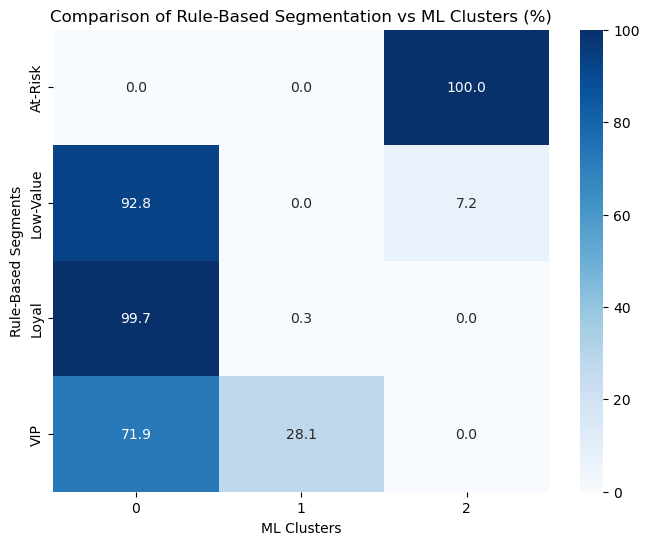

In [29]:
# Cross Tabulation of Clustering vs Rule-Based Segmentation
comparison_table = pd.crosstab(rfm['Rule_Segment'], rfm['KMeans_Cluster'], normalize='index') * 100

# Display comparison table
print(comparison_table)

# Optional: Plot as heatmap for better visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(comparison_table, annot=True, fmt=".1f", cmap="Blues")
plt.title("Comparison of Rule-Based Segmentation vs ML Clusters (%)")
plt.ylabel("Rule-Based Segments")
plt.xlabel("ML Clusters")
plt.show()


In [30]:
# Simple RFM rules (example)  
rfm['Rule_Based_Segment'] = np.where(
    rfm['Recency'] < 30, 
    'Active', 
    np.where(rfm['Monetary'] > 1000, 'HighValue', 'AtRisk')
)

# Compare with K-Means  
from sklearn.metrics import adjusted_rand_score  
print("Agreement with K-Means:", adjusted_rand_score(rfm['KMeans_Cluster'], rfm['Rule_Based_Segment']))  

Agreement with K-Means: 0.09982757673008089



o	Adjusted Rand Index (ARI):
The Adjusted Rand Index compares two clusterings (e.g., your K-Means result vs a rule-based segmentation) by measuring agreement between them, adjusted for chance.
o	1 = perfect match., 0.0 = random labeling.,	Negative = worse than random.
